In [60]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

## Задача 2.1

[1 балл] Сгенерируйте набор признаков  X  — двумерный массив размера  (1000×1) , состоящий из случайных вещественных чисел, равномерно распределённых по промежутку  [−1,2) . Затем получите набор меток  y  — одномерный массив размера  1000 , — по формуле:
y=3x−8x2+6x3.
Подсказка: может помочь numpy.random.uniform

Полностью векторизуйте решение, то есть избегайте явного использования циклов.

In [61]:
# Задаём размер выборки
n_samples = 1000

# Генерируем набор признаков X: 1000 случайных чисел из [-1, 2)
X = np.random.uniform(low=-1, high=2, size=(n_samples, 1))

# Вычисляем метки y по формуле: y = 3x - 8x^2 + 6x^3
y = 3 * X - 8 * X**2 + 6 * X**3

# Преобразуем y в одномерный массив (1000,)
y = y.ravel()

In [62]:
print(X[:10])

[[ 1.81949637]
 [ 0.88312416]
 [ 0.00471684]
 [-0.58218378]
 [ 1.38207557]
 [ 0.86021827]
 [ 0.60038328]
 [ 1.68167775]
 [ 1.36579163]
 [-0.54497536]]


In [63]:
print(y[:10])

[ 1.51153411e+01  5.42641300e-01  1.39731726e-02 -5.64200008e+00
  4.70485157e+00  4.80093550e-01  2.15954419e-01  1.09558250e+01
  4.46065861e+00 -4.98205126e+00]


Разделите  X,y  случайным образом на два фрагмента в соотношении  100÷900 . Удалите из первого фрагмента пары, в которых  x  лежит за пределами отрезка  [0,1] . Первый фрагмент мы далее будем называть тренировочным, второй — валидационным.

Подсказка: может помочь numpy.random.choice


In [64]:
def train_val_split(
      X:np.ndarray,
      y:np.ndarray,
      train_fraction:float=0.1,
      train_size:int=None,
      random_state:int=42,
    )->tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:

    """
    X : numpy.ndarray (n_samples, n_features) - массив признаков
    y : numpy.ndarray (n_samples) - массив меток

    train_fraction : optional, float - доля объектов, которую
    нужно отправить в тренировочную выборку
    аргумент игнорируется, если задан train_size

    train_size : optional, int - число объектов, которое
    нужно отправить в тренировочную выборку

    random_state : optional, int - аргумент,
    передаваемый генераторам случайных чисел
    (используется для воспроизводимости результатов)
    """

    if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
        raise TypeError("X и y должны быть numpy.ndarray")

    if X.size == 0 or y.size == 0:
        raise ValueError("X и y не должны быть пустыми массивами")



    np.random.seed(random_state)
    n_samples = X.shape[0]

    if train_size is None:
        train_size = int(n_samples * train_fraction)

    # Отбирает признаки случайно часть в train, остальное в валидацию
    train_indices = np.random.choice(n_samples, size=train_size, replace=False)
    val_indices = np.setdiff1d(np.arange(n_samples), train_indices)

    # Получаем тренировочный фрагмент
    X_train = X[train_indices]
    y_train = y[train_indices]

    # Делим данные по маске в промежутке от 0 до 1
    mask = (X_train >= 0) & (X_train <= 1)
    mask = mask.ravel()
    # Фильтрация данных по маске
    X_train = X_train[mask]
    y_train = y_train[mask].reshape(-1, 1)

    # Добавляем гауссов шум к тренировочным меткам
    y_train = y_train + np.random.normal(loc=0, scale=0.1, size=y_train.shape)

    # Получаем валидационный фрагмент
    X_val = X[val_indices]
    y_val = y[val_indices].reshape(-1, 1)

    return X_train, y_train, X_val, y_val

In [65]:
X_train, y_train, X_val, y_val = train_val_split(X, y, train_fraction=0.1, train_size=100, random_state=42)

print("Тренировочный фрагмент (X_train):", X_train.shape)
print("Тренировочный фрагмент (y_train):", y_train.shape)
print("Валидационный фрагмент (X_val):", X_val.shape)
print("Валидационный фрагмент (y_val):", y_val.shape)

Тренировочный фрагмент (X_train): (28, 1)
Тренировочный фрагмент (y_train): (28, 1)
Валидационный фрагмент (X_val): (900, 1)
Валидационный фрагмент (y_val): (900, 1)


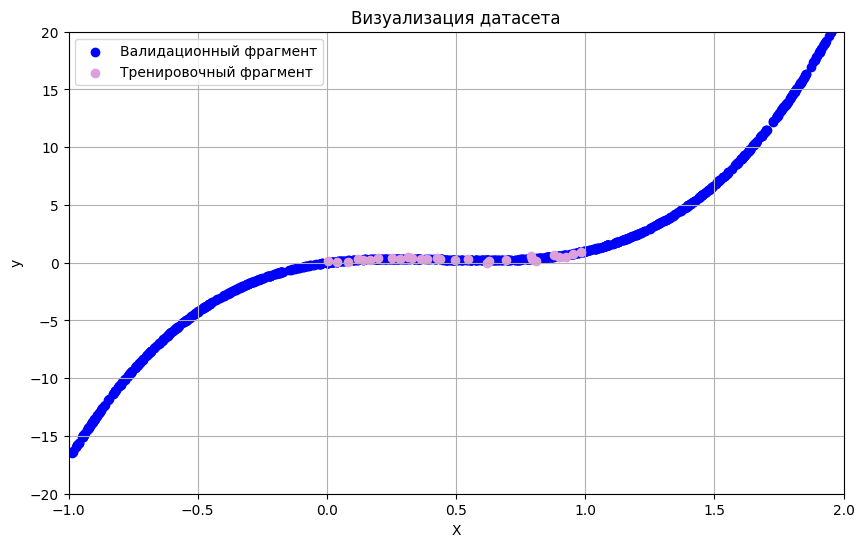

In [66]:
def plot_dataset(X_train, y_train, X_val, y_val):
    plt.figure(figsize=(10, 6))

    plt.scatter(X_val, y_val, color='blue', label='Валидационный фрагмент')

    # Тренировочные данные
    plt.scatter(X_train, y_train, color='plum', label='Тренировочный фрагмент')

    # Валидационные данные
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Визуализация датасета')
    plt.xlim(-1, 2)
    plt.ylim(-20, 20)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_dataset(X_train, y_train, X_val, y_val)

## Задача 2.2


In [67]:
class NumpyPolyLR:
    def __init__(self, d: int):
        d = int(d)
        if d < 1:
            raise ValueError("Степень d должна быть целым >= 1.")
        # Инициализация параметров, свободного члена
        self.d = d
        self.coef_ = None
        self.intercept_ = None
        self._fitted = False

    @staticmethod
    # Проверки на корректность данных и их очищение
    def _to_1d_numeric(a, name):
        try:
            x = np.asarray(a, dtype=float).reshape(-1)
        except Exception as e:
            raise ValueError(f"{name}: не удалось привести к числовому массиву (float).") from e
        return x

    def _clean_xy(self, X, y):
        x = self._to_1d_numeric(X, "X")
        y = self._to_1d_numeric(y, "y")
        if x.shape[0] != y.shape[0]:
            raise ValueError(f"Длины X и y не совпадают: {x.shape[0]} vs {y.shape[0]}.")
        if x.size == 0:
            raise ValueError("Пустые данные.")

        mask = np.isfinite(x) & np.isfinite(y)
        if not np.all(mask):
            removed = int((~mask).sum())
            warnings.warn(f"Удалены {removed} некорректных наблюдений (NaN/Inf).", RuntimeWarning)
            x = x[mask]; y = y[mask]

        if x.size < self.d + 1:
            raise ValueError(f"Слишком мало точек после очистки: {x.size}. Нужно >= {self.d+1}.")
        return x, y

    # Инициализация степеней
    def _phi(self, x):
        powers = np.arange(1, self.d + 1, dtype=float)
        return x[:, None] ** powers

    # Обучение модели
    def fit(self, X, y):
        x, y = self._clean_xy(X, y)
        P = self._phi(x)
        A = np.hstack([P, np.ones((P.shape[0], 1))])

        theta, residuals, rank, s = np.linalg.lstsq(A, y, rcond=None)
        if rank < A.shape[1]:
            warnings.warn("Дизайн-матрица вырождена (rank-deficient). Решение найдено в смысле МНК.", RuntimeWarning)

        self.coef_ = theta[:-1]
        self.intercept_ = float(theta[-1])
        self._fitted = True
        return self

    def predict(self, X):
        if not self._fitted:
            raise RuntimeError("Модель не обучена. Сначала вызовите .fit(X, y).")
        x = self._to_1d_numeric(X, "X")
        P = self._phi(x)
        return P @ self.coef_ + self.intercept_

In [68]:
# Аналог модели толькло с sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

degrees = range(1, 9+1)
curves = {}
metrics = []  # (lib, d, rmse_tr, rmse_v)

def rmse(a,b):
    a=np.asarray(a); b=np.asarray(b)
    return float(np.sqrt(np.mean((a-b)**2)))

grid = np.linspace(X.min(), X.max(), 300).reshape(-1,1)

for d in degrees:
    m = NumpyPolyLR(d).fit(X_train, y_train)
    ytr = m.predict(X_train); yv = m.predict(X_val)
    metrics.append(('numpy', d, rmse(y_train,ytr), rmse(y_val,yv)))
    curves[('np',d)] = (grid[:,0], m.predict(grid))

    pf = PolynomialFeatures(d, include_bias=False)
    Xtr_p = pf.fit_transform(X_train); Xv_p = pf.transform(X_val)
    lr = LinearRegression().fit(Xtr_p, y_train)
    ytr2 = lr.predict(Xtr_p); yv2 = lr.predict(Xv_p)
    metrics.append(('sklearn', d, rmse(y_train,ytr2), rmse(y_val,yv2)))
    curves[('sk',d)] = (grid[:,0], lr.predict(pf.transform(grid)))

In [69]:
# Параметры для d=3
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

d = 3
m3 = NumpyPolyLR(d).fit(X_train, y_train)
print('numpy d=3:', 'intercept=', m3.intercept_, 'coef=', m3.coef_)

pf = PolynomialFeatures(d, include_bias=False)
Xtr3 = pf.fit_transform(X_train)
lr3 = LinearRegression().fit(Xtr3, y_train)
print('sklearn d=3:', 'intercept=', float(lr3.intercept_), 'coef=', lr3.coef_)

numpy d=3: intercept= -0.016949885201345438 coef= [ 3.38712717 -8.82261468  6.4068103 ]
sklearn d=3: intercept= -0.016949885201332726 coef= [[ 3.38712717 -8.82261468  6.4068103 ]]


/tmp/ipython-input-996926222.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('sklearn d=3:', 'intercept=', float(lr3.intercept_), 'coef=', lr3.coef_)


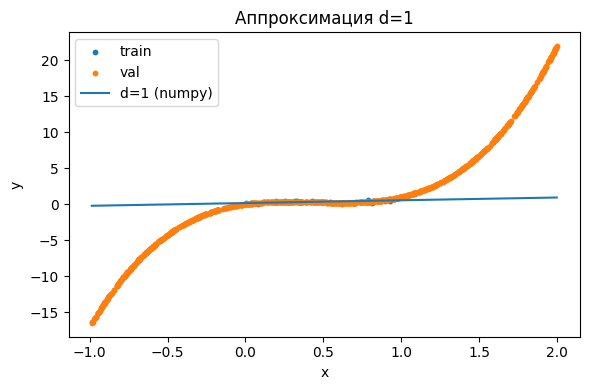

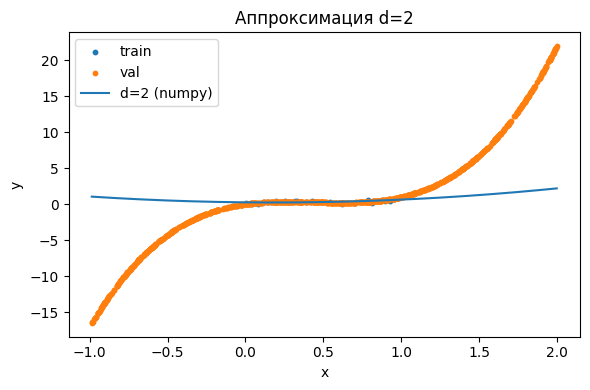

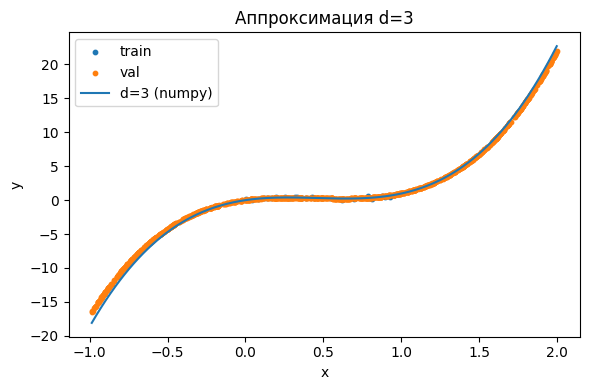

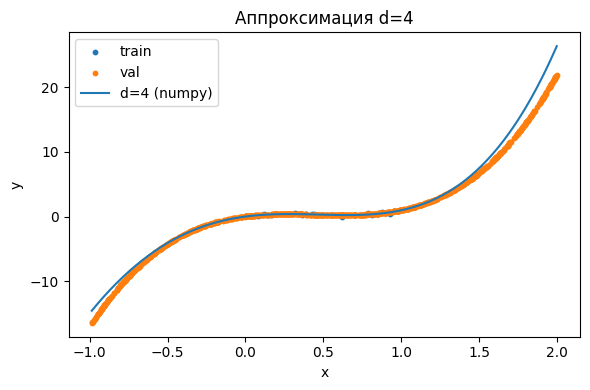

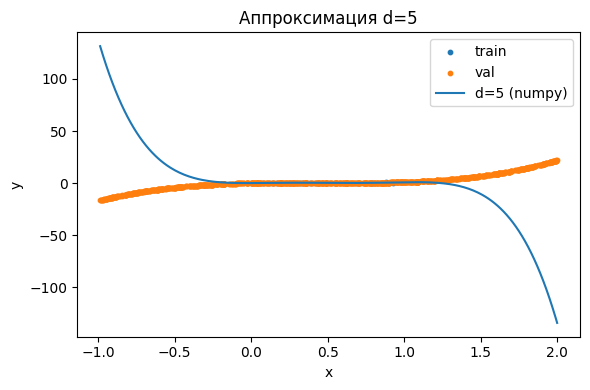

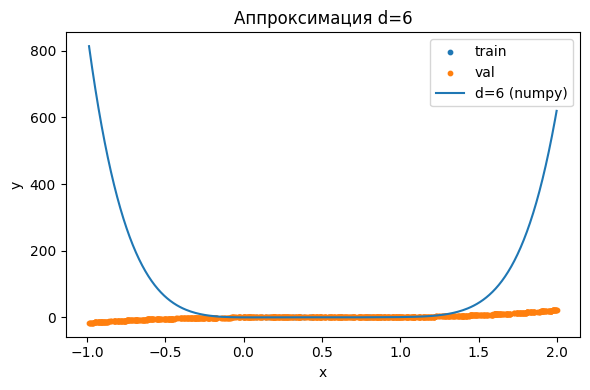

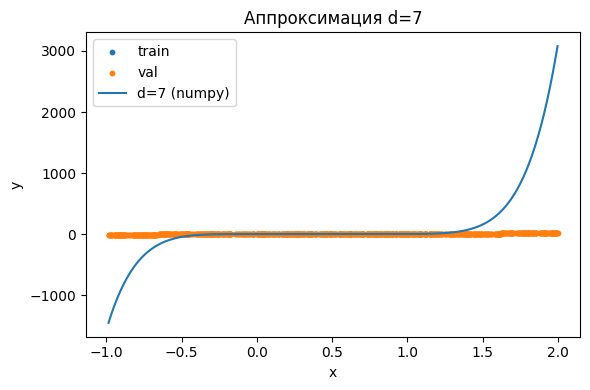

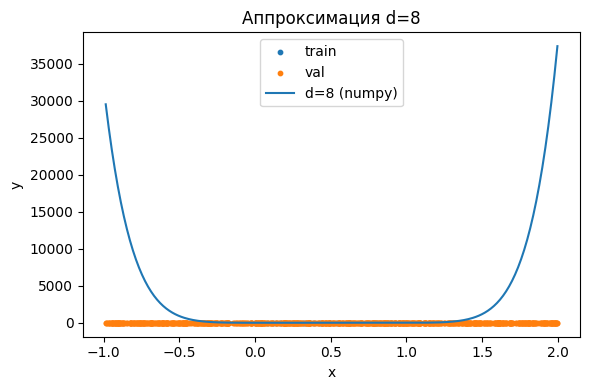

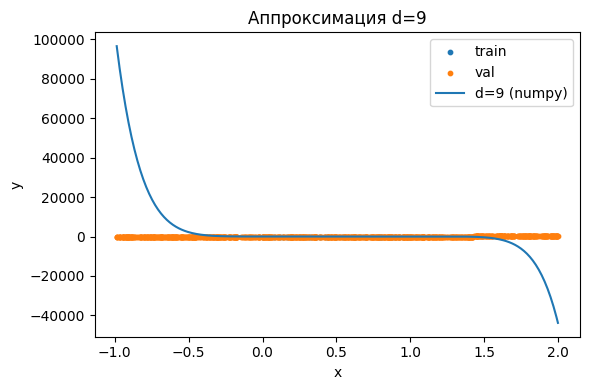

In [70]:
# Краткие графики: данные + аппроксимация (numpy) по нескольким d
for d in [1,2,3,4,5,6,7,8,9]:
    if ('np',d) not in curves:
        continue
    gx, gy = curves[('np',d)]
    plt.figure(figsize=(6,4))

    plt.scatter(X_train[:,0], y_train, s=10, label='train')
    plt.scatter(X_val[:,0],   y_val,   s=10, label='val')
    plt.plot(gx, gy, label=f'd={d} (numpy)')
    plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.title(f'Аппроксимация d={d}')
    plt.tight_layout()
    plt.show()

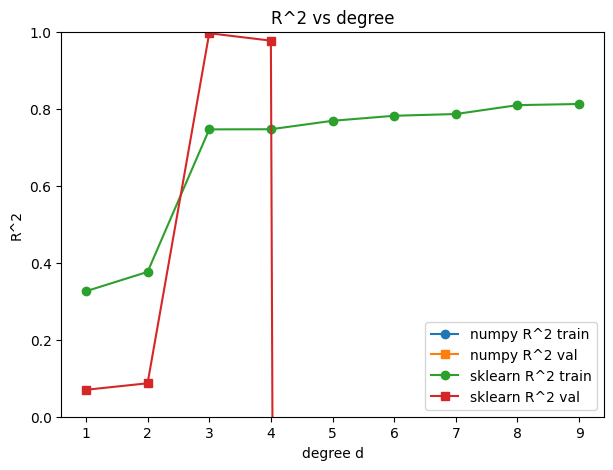

In [71]:
# Считаем R в квадрате, чем он больше тем лучше
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def r2(a,b):
    a=np.asarray(a); b=np.asarray(b)
    ssr = np.sum((a-b)**2); sst = np.sum((a-np.mean(a))**2)
    return float(1-ssr/sst) if sst>0 else 1.0

degrees = range(1, 10)
r2_np_tr, r2_np_v = [], []
r2_sk_tr, r2_sk_v = [], []

for d in degrees:
    # numpy
    m = NumpyPolyLR(d).fit(X_train, y_train)
    r2_np_tr.append(r2(y_train, m.predict(X_train)))
    r2_np_v .append(r2(y_val,   m.predict(X_val)))
    # sklearn
    pf = PolynomialFeatures(d, include_bias=False)
    Xtr_p = pf.fit_transform(X_train); Xv_p = pf.transform(X_val)
    lr = LinearRegression().fit(Xtr_p, y_train)
    r2_sk_tr.append(r2(y_train, lr.predict(Xtr_p)))
    r2_sk_v .append(r2(y_val,   lr.predict(Xv_p)))

plt.figure(figsize=(7,5))
plt.plot(list(degrees), r2_np_tr, marker='o', label='numpy R^2 train')
plt.plot(list(degrees), r2_np_v,  marker='s', label='numpy R^2 val')
plt.plot(list(degrees), r2_sk_tr, marker='o', label='sklearn R^2 train')
plt.plot(list(degrees), r2_sk_v,  marker='s', label='sklearn R^2 val')
plt.ylim(0, 1)
plt.xlabel('degree d'); plt.ylabel('R^2'); plt.title('R^2 vs degree'); plt.legend(); plt.show()
# масштаб - по y от 0 до 1